# Customer Churn Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Mobile Customer Departure**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
  1. [Relative cost of errors](#Relative-cost-of-errors)
1. [Extensions](#Extensions)

---

## Background

_This notebook has been adapted from an [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/)_

Losing customers is costly for any business.  Identifying unhappy customers early on gives you a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us–leaving a mobile phone operator.  Seems like I can always find fault with my provider! And if my provider knows that I’m thinking of leaving, it can offer timely incentives–I can always use a phone upgrade or perhaps have a new feature activated–and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

#### Change prefix in the cell above to add a unique tag, like your name 

In [9]:
bucket = 'wsaar-us-east-1-9XXXXXXXXXXX-wkr-ml-temp'

# Change sufix to your userid. 
prefix = 'ChurnPrediction-ankamv'

    
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [10]:
## Take the s3 Data Path from the Dataset description 

s3_path = "s3://wsaar-us-east-1-9XXXXXXXXXXX-wkr-dlz/workshop/Telecom_Churn_Data/"
bucket_name = s3_path.split("/")[2]
prefix_original_data="/".join(s3_path.split("/")[3:])

In [11]:
## Code for reading all files from the Dataset

import pandas as pd

def read_prefix_to_df(bucket_name,prefix):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    prefix_objs = bucket.objects.filter(Prefix=prefix)
    prefix_df = []
    for obj in prefix_objs:
        key = "s3://" + bucket_name + "/"+obj.key 
        print(key)
        df = pd.read_csv(key)
        prefix_df.append(df)
    return pd.concat(prefix_df)

In [12]:
### Read all files from Dataset 
churn = read_prefix_to_df(bucket_name,prefix_original_data)

s3://wsaar-us-east-1-9XXXXXXXXXXX-wkr-dlz/workshop/Telecom_Churn_Data/upload_date=1622701977/ankamv_5e6b2b3a-11b4-45a9-9197-ea23db4f3e4a_1622701977_churn.csv


Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `AccountLength`: the number of days that this account has been active
- `AreaCode`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `IntlPlan`: whether the customer has an international calling plan: yes/no
- `VMailPlan`: whether the customer has a voice mail feature: yes/no
- `VMailMessage`: presumably the average number of voice mail messages per month
- `DayMins`: the total number of calling minutes used during the day
- `DayCalls`: the total number of calls placed during the day
- `DayCharge`: the billed cost of daytime calls
- `EveMins, EveCalls, EveCharge`: the billed cost for calls placed during the evening
- `NightMins`, `NightCalls`, `NightCharge`: the billed cost for calls placed during nighttime
- `IntlMins`, `IntlCalls`, `IntlCharge`: the billed cost for international calls
- `CustServCalls`: the number of calls placed to Customer Service
- `Churn`: whether the customer left the service: true/false

The last attribute, `Churn`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

In [14]:
pd.set_option('display.max_columns', 500)
churn['Churn'] = churn['Churn'].astype(object)
churn.head()

State  AccountLength  AreaCode     Phone IntlPlan VMailPlan  VMailMessage  \
0    KS            128       415  382-4657       no       yes            25   
1    OH            107       415  371-7191       no       yes            26   
2    NJ            137       415  358-1921       no        no             0   
3    OH             84       408  375-9999      yes        no             0   
4    OK             75       415  330-6626      yes        no             0   

   DayMins  DayCalls  DayCharge  EveMins  EveCalls  EveCharge  NightMins  \
0    265.1       110      45.07    197.4        99      16.78      244.7   
1    161.6       123      27.47    195.5       103      16.62      254.4   
2    243.4       114      41.38    121.2       110      10.30      162.6   
3    299.4        71      50.90     61.9        88       5.26      196.9   
4    166.7       113      28.34    148.3       122      12.61      186.9   

   NightCalls  NightCharge  IntlMins  IntlCalls  IntlCharge  CustServCalls  \
0          91        11.01      10.0          3        2.70              1   
1         103        11.45      13.7          3        3.70              1   
2         104         7.32      12.2          5        3.29              0   
3          89         8.86       6.6          7        1.78              2   
4         121         8.41      10.1          3        2.73              3   

   Churn  
0  False  
1  False  
2  False  
3  False  
4  False

##### Churn Count
Looking at the distribution of the target attribute, Churn, we see that 483 out of 3,333 customers, or approximately 14.49 %, did churn. As you will see later, this is an important statistic for deciding whether the trained model is usable.

<AxesSubplot:title={'center':'Churn Count'}>

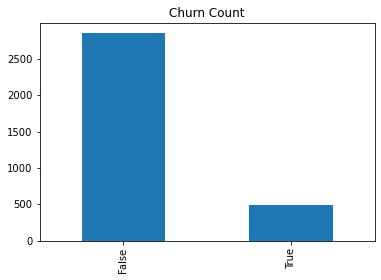

In [15]:
churn.Churn.value_counts().plot(kind="bar",title="Churn Count")

col_0  % observations
State                
AK           0.015602
AL           0.024002
AR           0.016502
AZ           0.019202
CA           0.010201
CO           0.019802
CT           0.022202
DC           0.016202
DE           0.018302
FL           0.018902
GA           0.016202
HI           0.015902
IA           0.013201
ID           0.021902
IL           0.017402
IN           0.021302
KS           0.021002
KY           0.017702
LA           0.015302
MA           0.019502
MD           0.021002
ME           0.018602
MI           0.021902
MN           0.025203
MO           0.018902
MS           0.019502
MT           0.020402
NC           0.020402
ND           0.018602
NE           0.018302
NH           0.016802
NJ           0.020402
NM           0.018602
NV           0.019802
NY           0.024902
OH           0.023402
OK           0.018302
OR           0.023402
PA           0.013501
RI           0.019502
SC           0.018002
SD           0.018002
TN           0.015902
TX           0.021602
UT           0.021602
VA           0.023102
VT           0.021902
WA           0.019802
WI           0.023402
WV           0.031803
WY           0.023102

col_0     % observations
Phone                   
327-1058          0.0003
327-1319          0.0003
327-3053          0.0003
327-3587          0.0003
327-3850          0.0003
...                  ...
422-7728          0.0003
422-8268          0.0003
422-8333          0.0003
422-8344          0.0003
422-9964          0.0003

[3333 rows x 1 columns]

col_0     % observations
IntlPlan                
no               0.90309
yes              0.09691

col_0      % observations
VMailPlan                
no               0.723372
yes              0.276628

col_0  % observations
Churn                
False        0.855086
True         0.144914

AccountLength     AreaCode  VMailMessage      DayMins     DayCalls  \
count    3333.000000  3333.000000   3333.000000  3333.000000  3333.000000   
mean      101.064806   437.182418      8.099010   179.775098   100.435644   
std        39.822106    42.371290     13.688365    54.467389    20.069084   
min         1.000000   408.000000      0.000000     0.000000     0.000000   
25%        74.000000   408.000000      0.000000   143.700000    87.000000   
50%       101.000000   415.000000      0.000000   179.400000   101.000000   
75%       127.000000   510.000000     20.000000   216.400000   114.000000   
max       243.000000   510.000000     51.000000   350.800000   165.000000   

         DayCharge      EveMins     EveCalls    EveCharge    NightMins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

        NightCalls  NightCharge     IntlMins    IntlCalls   IntlCharge  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711     9.039325    10.237294     4.479448     2.764581   
std      19.568609     2.275873     2.791840     2.461214     0.753773   
min      33.000000     1.040000     0.000000     0.000000     0.000000   
25%      87.000000     7.520000     8.500000     3.000000     2.300000   
50%     100.000000     9.050000    10.300000     4.000000     2.780000   
75%     113.000000    10.590000    12.100000     6.000000     3.270000   
max     175.000000    17.770000    20.000000    20.000000     5.400000   

       CustServCalls  
count    3333.000000  
mean        1.562856  
std         1.315491  
min         0.000000  
25%         1.000000  
50%         1.000000  
75%         2.000000  
max         9.000000

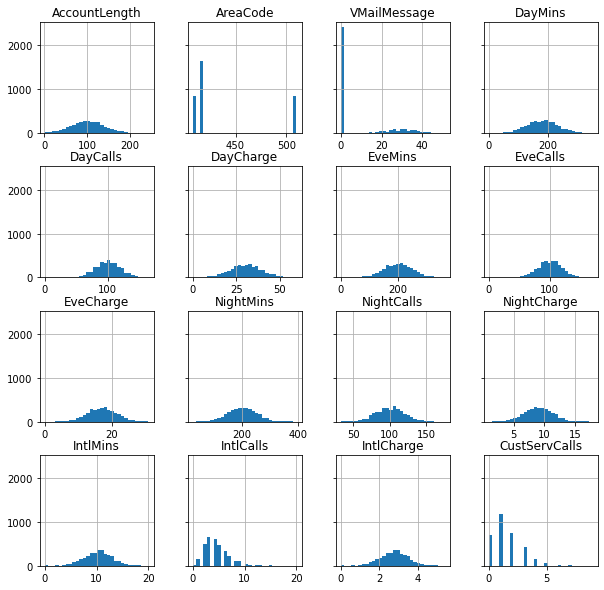

In [16]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

We can see immediately that:
- `State` appears to be quite evenly distributed
- `Phone` takes on too many unique values to be of any practical use.  It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

###### Churn Likelihood w.r.t States

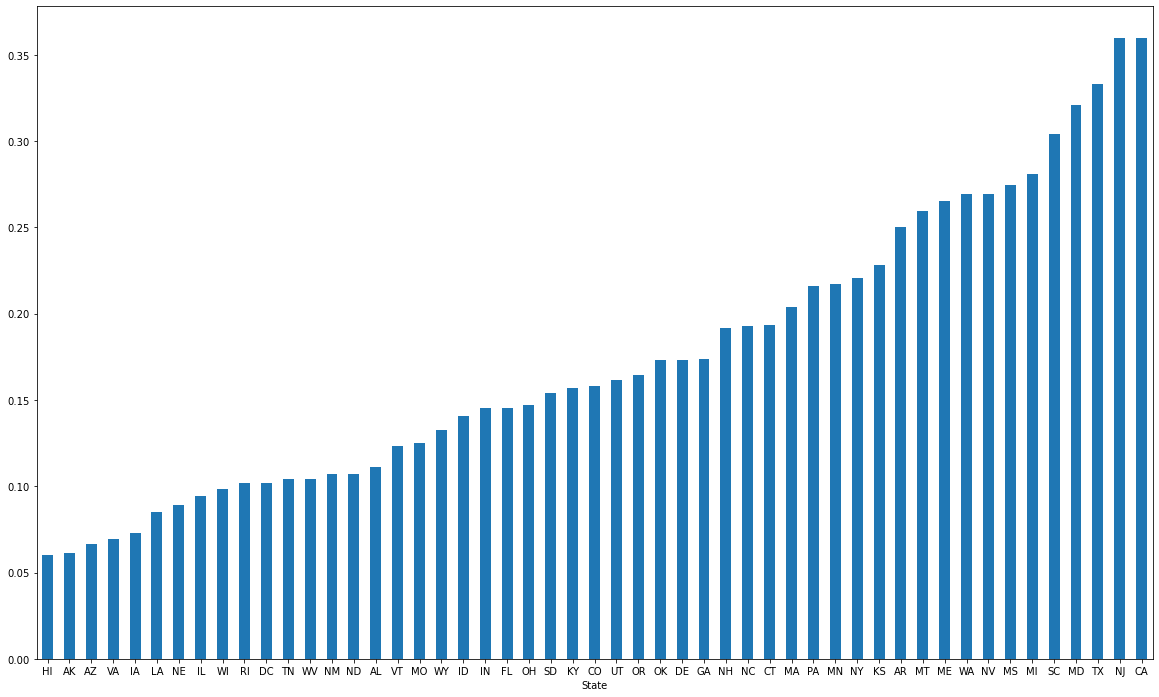

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 12, forward=True)
temp_data = pd.crosstab(churn["Churn"],churn["State"])
temp_data = temp_data.loc[True] / temp_data.loc[False]
temp_data.sort_values().plot(kind="bar", rot=0,ax = axes);

In [18]:
churn = churn.drop('Phone', axis=1)
churn['AreaCode'] = churn['AreaCode'].astype(object)

Next let's look at the relationship between each of the features and our target variable.

Churn     False     True 
State                    
AK     0.017193  0.006211
AL     0.025263  0.016563
AR     0.015439  0.022774
AZ     0.021053  0.008282
CA     0.008772  0.018634
CO     0.020000  0.018634
CT     0.021754  0.024845
DC     0.017193  0.010352
DE     0.018246  0.018634
FL     0.019298  0.016563
GA     0.016140  0.016563
HI     0.017544  0.006211
IA     0.014386  0.006211
ID     0.022456  0.018634
IL     0.018596  0.010352
IN     0.021754  0.018634
KS     0.020000  0.026915
KY     0.017895  0.016563
LA     0.016491  0.008282
MA     0.018947  0.022774
MD     0.018596  0.035197
ME     0.017193  0.026915
MI     0.020000  0.033126
MN     0.024211  0.031056
MO     0.019649  0.014493
MS     0.017895  0.028986
MT     0.018947  0.028986
NC     0.020000  0.022774
ND     0.019649  0.012422
NE     0.019649  0.010352
NH     0.016491  0.018634
NJ     0.017544  0.037267
NM     0.019649  0.012422
NV     0.018246  0.028986
NY     0.023860  0.031056
OH     0.023860  0.020704
OK     0.018246  0.018634
OR     0.023509  0.022774
PA     0.012982  0.016563
RI     0.020702  0.012422
SC     0.016140  0.028986
SD     0.018246  0.016563
TN     0.016842  0.010352
TX     0.018947  0.037267
UT     0.021754  0.020704
VA     0.025263  0.010352
VT     0.022807  0.016563
WA     0.018246  0.028986
WI     0.024912  0.014493
WV     0.033684  0.020704
WY     0.023860  0.018634

Churn        False     True 
AreaCode                    
408       0.251228  0.252588
415       0.497895  0.488613
510       0.250877  0.258799

Churn        False     True 
IntlPlan                    
no        0.934737  0.716356
yes       0.065263  0.283644

Churn         False     True 
VMailPlan                    
no         0.704561  0.834369
yes        0.295439  0.165631

AccountLength


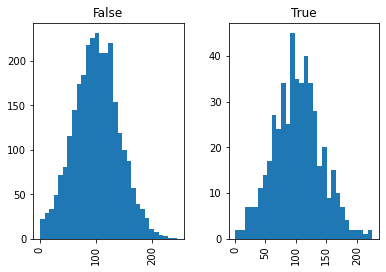

VMailMessage


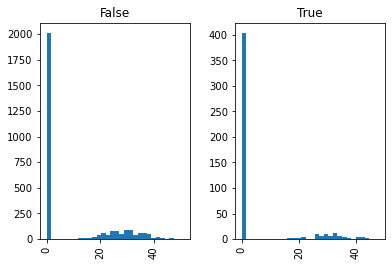

DayMins


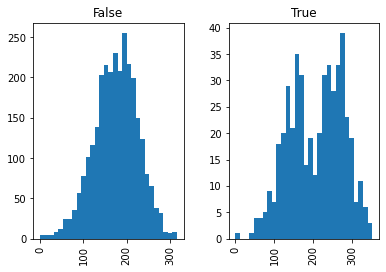

DayCalls


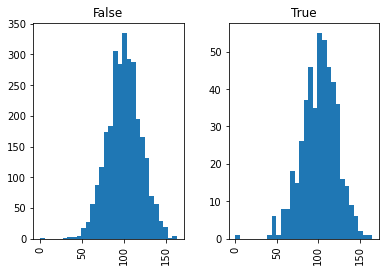

DayCharge


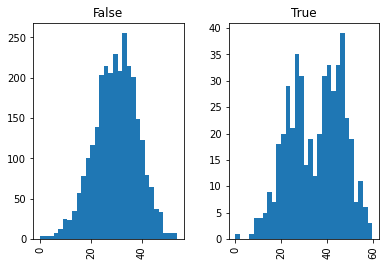

EveMins


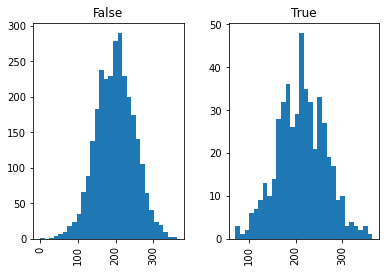

EveCalls


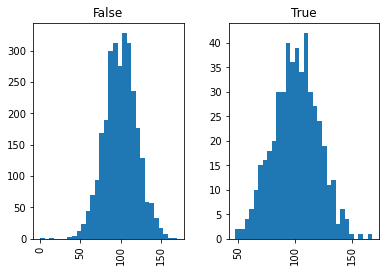

EveCharge


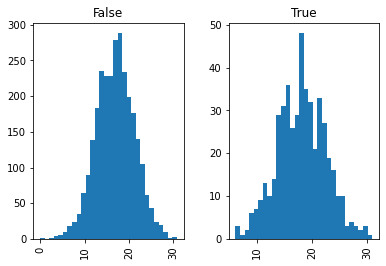

NightMins


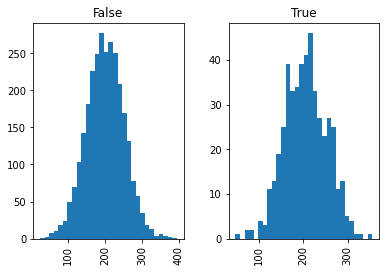

NightCalls


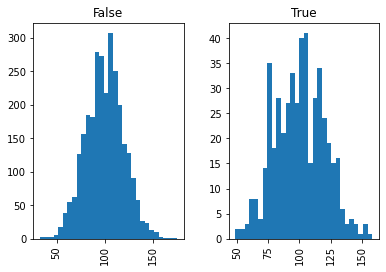

NightCharge


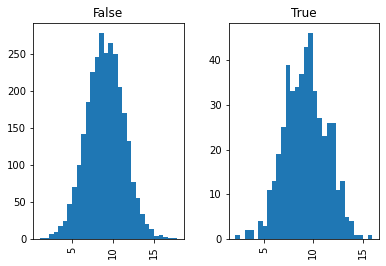

IntlMins


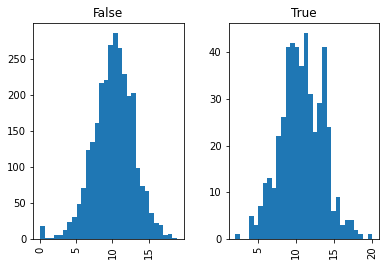

IntlCalls


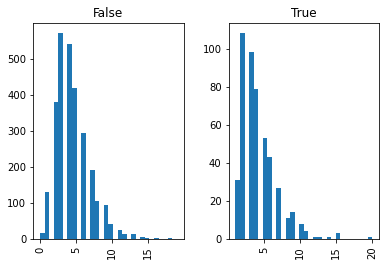

IntlCharge


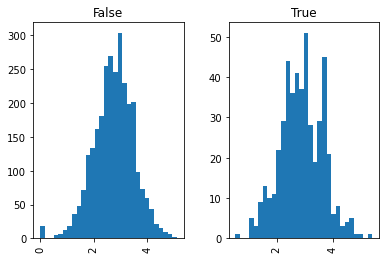

CustServCalls


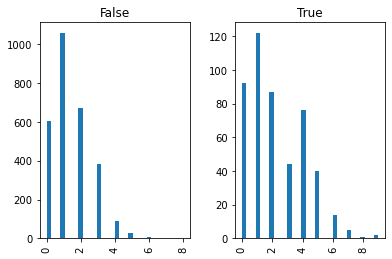

In [19]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn':
        display(pd.crosstab(index=churn[column], columns=churn['Churn'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn']].hist(by='Churn', bins=30)
    plt.show()

Interestingly we see that churners appear:

Fairly evenly distributed geographically
More likely to have an international plan
Less likely to have a voicemail plan
To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)
In addition, we see that churners take on very similar distributions for features like Day Mins and Day Charge. That's not surprising as we'd expect minutes spent talking to correlate with charges. Let's dig deeper into the relationships between our features.

AccountLength  VMailMessage   DayMins  DayCalls  DayCharge  \
AccountLength       1.000000     -0.004628  0.006216  0.038470   0.006214   
VMailMessage       -0.004628      1.000000  0.000778 -0.009548   0.000776   
DayMins             0.006216      0.000778  1.000000  0.006750   1.000000   
DayCalls            0.038470     -0.009548  0.006750  1.000000   0.006753   
DayCharge           0.006214      0.000776  1.000000  0.006753   1.000000   
EveMins            -0.006757      0.017562  0.007043 -0.021451   0.007050   
EveCalls            0.019260     -0.005864  0.015769  0.006462   0.015769   
EveCharge          -0.006745      0.017578  0.007029 -0.021449   0.007036   
NightMins          -0.008955      0.007681  0.004323  0.022938   0.004324   
NightCalls         -0.013176      0.007123  0.022972 -0.019557   0.022972   
NightCharge        -0.008960      0.007663  0.004300  0.022927   0.004301   
IntlMins            0.009514      0.002856 -0.010155  0.021565  -0.010157   
IntlCalls           0.020661      0.013957  0.008033  0.004574   0.008032   
IntlCharge          0.009546      0.002884 -0.010092  0.021666  -0.010094   
CustServCalls      -0.003796     -0.013263 -0.013423 -0.018942  -0.013427   

                EveMins  EveCalls  EveCharge  NightMins  NightCalls  \
AccountLength -0.006757  0.019260  -0.006745  -0.008955   -0.013176   
VMailMessage   0.017562 -0.005864   0.017578   0.007681    0.007123   
DayMins        0.007043  0.015769   0.007029   0.004323    0.022972   
DayCalls      -0.021451  0.006462  -0.021449   0.022938   -0.019557   
DayCharge      0.007050  0.015769   0.007036   0.004324    0.022972   
EveMins        1.000000 -0.011430   1.000000  -0.012584    0.007586   
EveCalls      -0.011430  1.000000  -0.011423  -0.002093    0.007710   
EveCharge      1.000000 -0.011423   1.000000  -0.012592    0.007596   
NightMins     -0.012584 -0.002093  -0.012592   1.000000    0.011204   
NightCalls     0.007586  0.007710   0.007596   0.011204    1.000000   
NightCharge   -0.012593 -0.002056  -0.012601   0.999999    0.011188   
IntlMins      -0.011035  0.008703  -0.011043  -0.015207   -0.013605   
IntlCalls      0.002541  0.017434   0.002541  -0.012353    0.000305   
IntlCharge    -0.011067  0.008674  -0.011074  -0.015180   -0.013630   
CustServCalls -0.012985  0.002423  -0.012987  -0.009288   -0.012802   

               NightCharge  IntlMins  IntlCalls  IntlCharge  CustServCalls  
AccountLength    -0.008960  0.009514   0.020661    0.009546      -0.003796  
VMailMessage      0.007663  0.002856   0.013957    0.002884      -0.013263  
DayMins           0.004300 -0.010155   0.008033   -0.010092      -0.013423  
DayCalls          0.022927  0.021565   0.004574    0.021666      -0.018942  
DayCharge         0.004301 -0.010157   0.008032   -0.010094      -0.013427  
EveMins          -0.012593 -0.011035   0.002541   -0.011067      -0.012985  
EveCalls         -0.002056  0.008703   0.017434    0.008674       0.002423  
EveCharge        -0.012601 -0.011043   0.002541   -0.011074      -0.012987  
NightMins         0.999999 -0.015207  -0.012353   -0.015180      -0.009288  
NightCalls        0.011188 -0.013605   0.000305   -0.013630      -0.012802  
NightCharge       1.000000 -0.015214  -0.012329   -0.015186      -0.009277  
IntlMins         -0.015214  1.000000   0.032304    0.999993      -0.009640  
IntlCalls        -0.012329  0.032304   1.000000    0.032372      -0.017561  
IntlCharge       -0.015186  0.999993   0.032372    1.000000      -0.009675  
CustServCalls    -0.009277 -0.009640  -0.017561   -0.009675       1.000000

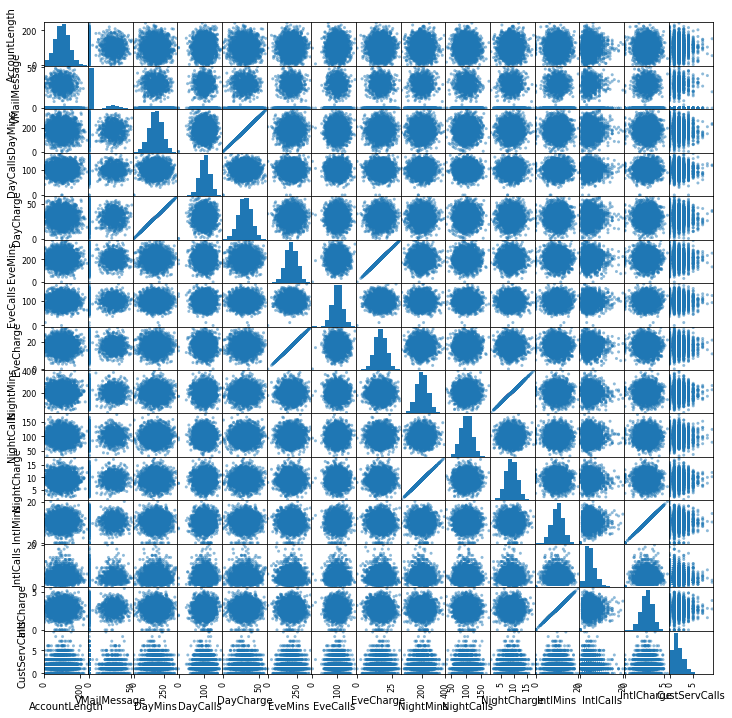

In [20]:
display(churn.corr())
pd.plotting.scatter_matrix(churn, figsize=(12, 12))
plt.show()

We see several features that essentially have 100% correlation with one another. Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias. Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [21]:
churn = churn.drop(['DayCharge', 'EveCharge', 'NightCharge', 'IntlCharge'], axis=1)
churn.shape

(3333, 16)

Now that we've cleaned up our dataset, let's determine which algorithm to use. As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn. In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms. Instead, let's attempt to model this problem using gradient boosted trees. Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint. XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. For this example, we'll stick with CSV. It should:

Have the predictor variable in the first column
Not have a header row
But first, let's convert our categorical features into numeric features.

In [22]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn_True'], model_data.drop(['Churn_False', 'Churn_True'], axis=1)], axis=1)
model_data.shape

(3333, 70)

And now let's split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [23]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data[test_data.columns[1:]].to_csv('test.csv',header=False,index=False)

Now we'll upload these files to S3.

In [24]:

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [29]:
#from sagemaker.amazon.amazon_estimator import get_image_uri
#container = get_image_uri(boto3.Session().region_name, 'xgboost')

from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

Then, because we're training with the CSV file format, we'll create `TrainingInput`s that our training function can use as a pointer to the files in S3.

In [34]:
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')


Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [36]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2021-06-03 06:53:27 Starting - Starting the training job...
2021-06-03 06:53:29 Starting - Launching requested ML instancesProfilerReport-1622703207: InProgress
......
2021-06-03 06:54:41 Starting - Preparing the instances for training......
2021-06-03 06:55:54 Downloading - Downloading input data...
2021-06-03 06:56:27 Training - Downloading the training image..Arguments: train
[2021-06-03:06:56:31:INFO] Running standalone xgboost training.
[2021-06-03:06:56:31:INFO] File size need to be processed in the node: 0.46mb. Available memory size in the node: 8398.06mb
[2021-06-03:06:56:31:INFO] Determined delimiter of CSV input is ','
[06:56:31] S3DistributionType set as FullyReplicated
[06:56:31] 2333x69 matrix with 160977 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-06-03:06:56:31:INFO] Determined delimiter of CSV input is ','
[06:56:31] S3DistributionType set as FullyReplicated
[06:56:31] 666x69 matrix with 45954 entries loaded from /opt/ml/inp

In [37]:
%time
sage_session = boto3.Session().client(service_name='sagemaker') 

## model name must change for each user
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
print(timestamp)
model_name="churn-xgboost"+"-"+timestamp

print(model_name)

### Model S3 Artifact Location
model_data = xgb.model_data
print(model_data)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
-2021-06-03-06-58-04
churn-xgboost--2021-06-03-06-58-04
s3://wsaar-us-east-1-9XXXXXXXXXXX-wkr-ml-temp/ChurnPrediction-ankamv/output/xgboost-2021-06-03-06-53-27-718/output/model.tar.gz


In [38]:
primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = sage_session.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:9XXXXXXXXXXX:model/churn-xgboost--2021-06-03-06-58-04


In [39]:
input_test_location = 's3://{}/{}/test/test.csv'.format(bucket, prefix)
output_location = 's3://{}/{}/output'.format(bucket,prefix)

In [40]:
# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=output_location
    )

In [41]:
# Initialize the transformer object
transformer =sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=output_location
    )


transformer.transform(input_test_location, content_type='text/csv', split_type='Line')
# Then wait until the transform job has completed
transformer.wait()

# Fetch train result 
s3_client = boto3.client('s3')
s3_client.download_file(bucket, '{}/output/test.csv.out'.format(prefix), 'test-result')
with open('test-result') as f:
    test_results = f.readlines() 
test_results = [float(i.replace("\n","")) for i in test_results]
test_data['churn-pred'] = test_results

................................Arguments: serve
[2021-06-03 07:04:49 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-06-03 07:04:49 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-06-03 07:04:49 +0000] [1] [INFO] Using worker: gevent
[2021-06-03 07:04:49 +0000] [20] [INFO] Booting worker with pid: 20
[2021-06-03 07:04:49 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)', 'urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)']. 
  monkey.patch_all(subprocess=True)
[2021-06-0

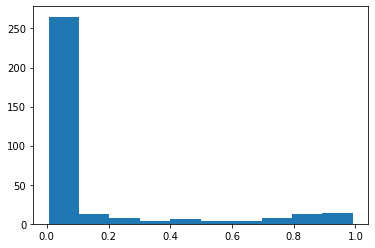

In [42]:
plt.hist(test_results)
plt.show()

#### Confusion Matrix

In [43]:
pd.crosstab(index=test_data.iloc[:, 0], columns= test_data['churn-pred'] > 0.3)

churn-pred  False  True 
Churn_True              
0             278      8
1               7     41

#### Recall

In [44]:
from sklearn.metrics import recall_score,precision_score,f1_score
recall_score(test_data.iloc[:, 0], test_data['churn-pred'] > 0.3)


0.8541666666666666

#### Precision

In [45]:
precision_score(test_data.iloc[:, 0], test_data['churn-pred'] > 0.3)

0.8367346938775511

#### F1 Score

In [46]:
f1_score(test_data.iloc[:, 0], test_data['churn-pred'] > 0.3)

0.845360824742268